# Time Series on Seattle Bike Data
---
I followed a time series analysis tutorial on [Seattle bike data](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k) based on this blog post: [Is Seattle Really Seeing an Uptick In Cycling?](http://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/)

# 1. The Data
- Bike data from [data.seattle.gov](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k)
- Weather data from [National Climatic Data Center](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (2012/10/1 - 2014/5/14)

# 2. Examining the Fremont Bridge Data

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set('talk')
sns.set_style("whitegrid")
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 7 # change default figure size

## Load the bike data

In [81]:
df = pd.read_csv("data/Seattle_bike.csv")
df.head()

,Date,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
0,10/03/2012 12:00:00 AM,4,9
1,10/03/2012 01:00:00 AM,4,6
2,10/03/2012 02:00:00 AM,1,1
3,10/03/2012 03:00:00 AM,2,3
4,10/03/2012 04:00:00 AM,6,1


In [82]:
# Load the data file, and create a column with total north/south traffic

hourly = pd.read_csv("data/Seattle_bike.csv", index_col='Date', parse_dates=True)
# index_col: Column to use as the row labels of the DataFrame. 
# parse_dates: If True -> try parsing the index. 

# West Sidewalk -> northbound, East Sidewalk -> southbound
hourly.columns = ['northbound', 'southbound']
hourly['total'] = hourly['northbound'] + hourly['southbound']
print hourly.head()

                     northbound  southbound  total
Date                                              
2012-10-03 00:00:00           4           9     13
2012-10-03 01:00:00           4           6     10
2012-10-03 02:00:00           1           1      2
2012-10-03 03:00:00           2           3      5
2012-10-03 04:00:00           6           1      7


In [83]:
# Resample the data into daily and weekly totals
"""
    pandas.DataFrame.resample
    - Convenience method for frequency conversion and resampling of regular time-series data.
"""
daily = hourly.resample('d', 'sum')
weekly = daily.resample('w', 'sum')

print daily.head()
print weekly.head()

            northbound  southbound  total
Date                                     
2012-10-03        1760        1761   3521
2012-10-04        1708        1767   3475
2012-10-05        1558        1590   3148
2012-10-06        1080         926   2006
2012-10-07        1191         951   2142
            northbound  southbound  total
Date                                     
2012-10-07        7297        6995  14292
2012-10-14        8679        8116  16795
2012-10-21        7946        7563  15509
2012-10-28        6901        6536  13437
2012-11-04        6408        5786  12194


## Plot the raw data

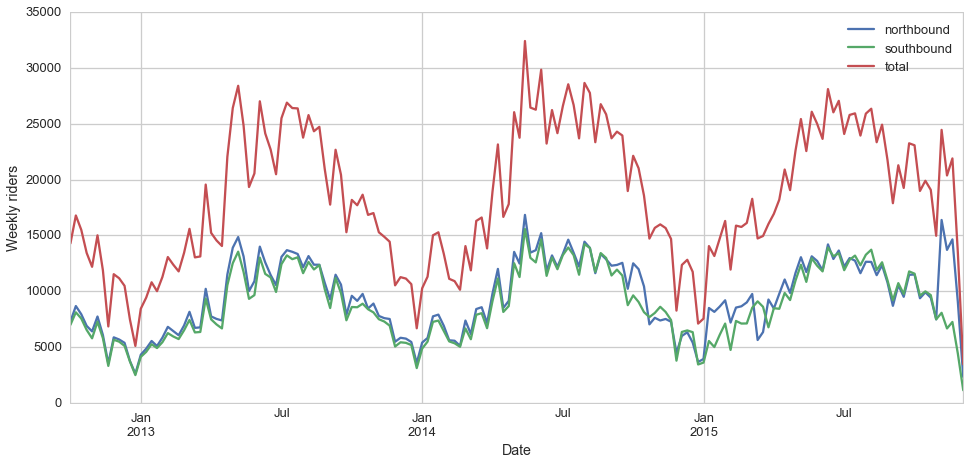

In [84]:
weekly[['northbound', 'southbound', 'total']].plot()
plt.ylabel('Weekly riders');

At first glance, **April and May 2014** include some spikes in the data: over 32,000 riders per week crossed the bridge one week in May! This trend might be a bit clearer if we use a **moving window average**: basically, for each day we'll take the average of the 30-day period around it:

## Plot the rolling mean

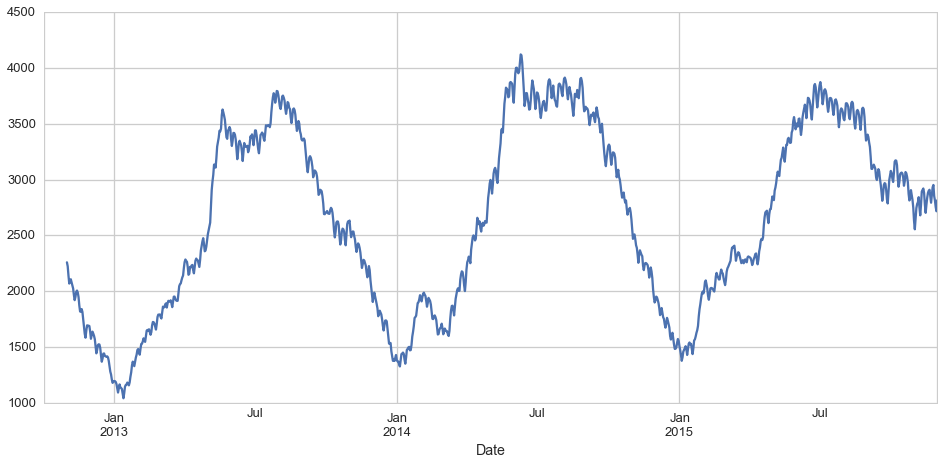

In [85]:
"""pandas provide moving (rolling) statics"""

# the methods are in the pandas namespace, but otherwise they can be found in pandas.stats.moments
pd.stats.moments.rolling_mean(daily['total'], 30).plot(); # pd.rolling_mean also works

This is the increased ridership that folks have been talking about. There is some seasonal variation, but the trend seems clear: **2014 has seen a lot of cyclists crossing the bridge.**

## Seasonal variation
But it is clear that there is still some **seasonal variation**. What we're going to try to do below is to model this variation based on our intuition about what factors might come into play in people's decision about whether to ride.

For simplicity, we are using a **linear model** here. It would be possible to go deeper and use a more sophisticated model (I'd eventually like to try Random Forests), but a linear model should give us a good approximation of what's happening.

# Step 1: Accounting for hours of daylight
## Hypothesis: The swing is at least partially due to the changing daylight hours
We'll compute the number of hours of daylight and use this to de-trend the data.
### The hours of daylight for the given date

In [86]:
# Define a function which returns the hours of daylight given the day of the year, from 0 to 365

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# add this to our weekly data
weekly['daylight'] = map(hours_of_daylight, weekly.index)
daily['daylight'] = map(hours_of_daylight, daily.index)

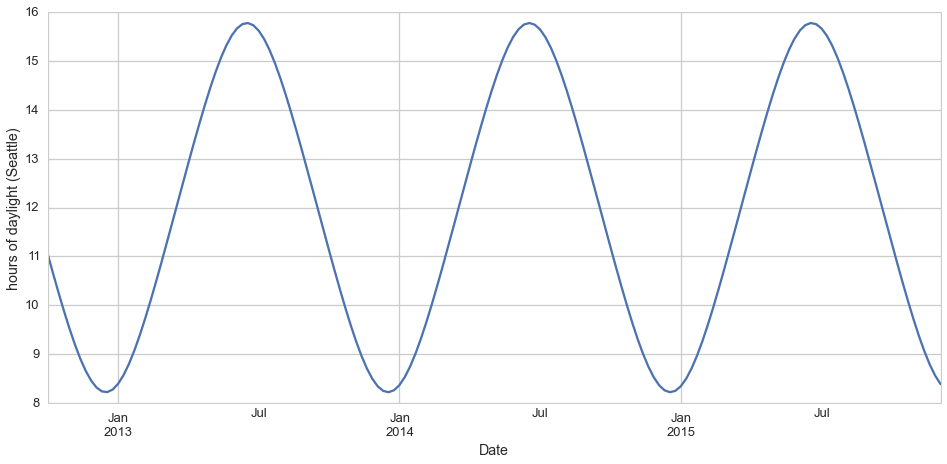

In [87]:
# Plot the daylight curve

weekly['daylight'].plot()
plt.ylabel('hours of daylight (Seattle)');

### The daylight hours vs. the weekly bicycle traffic

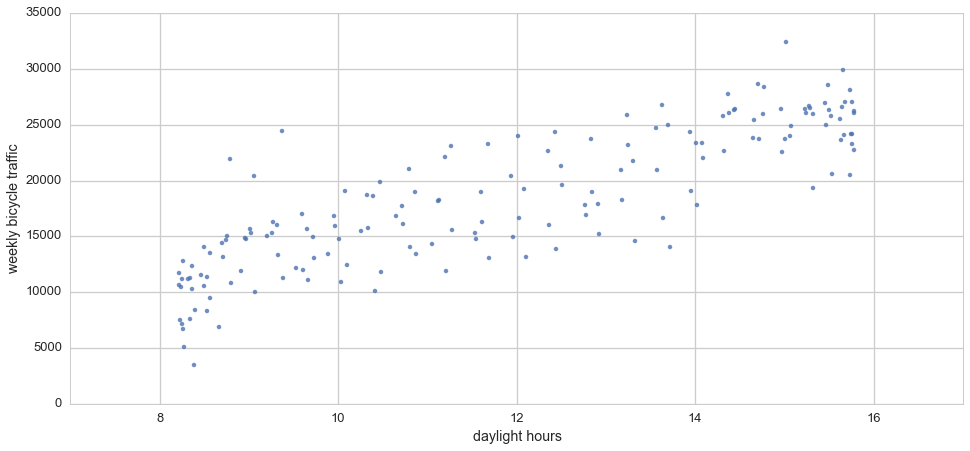

In [88]:
# seaborn
sns.regplot(weekly['daylight'], weekly['total'], fit_reg=False)
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

## Building a linear model

In [101]:
print weekly[['daylight']].head()

             daylight
Date                 
2012-10-07  11.045208
2012-10-14  10.644852
2012-10-21  10.255305
2012-10-28   9.881095
2012-11-04   9.527645


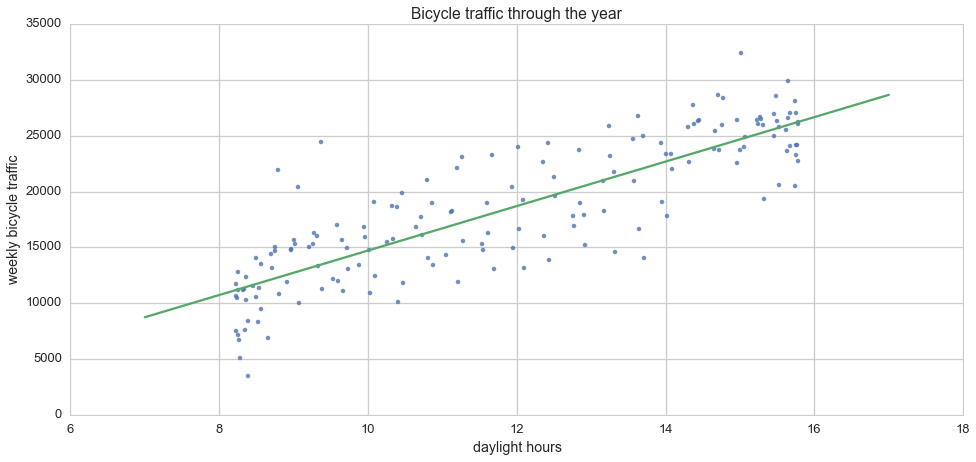

In [102]:
from sklearn.linear_model import LinearRegression

# X = weekly[['daylight']].to_dense() # this is to create X as df (or dense matrix)
# For a single column, pandas single bracket returns a Series, double bracket returns a DataFrame
X = weekly[['daylight']]
y = weekly['total']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly['total'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])

# seaborn
sns.regplot(weekly['daylight'], weekly['total'], fit_reg=False)
plt.plot(xfit, yfit)
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');